In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LGE_CNN.git # colab 사용 시
%cd /content/2024_LGE_CNN # Local PC로 실습하는 경우 실행 x / 단 작업경로를 2024_LGE_CNN으로 맞춰주기

In [2]:
# !pip install IPython
from IPython.display import Image

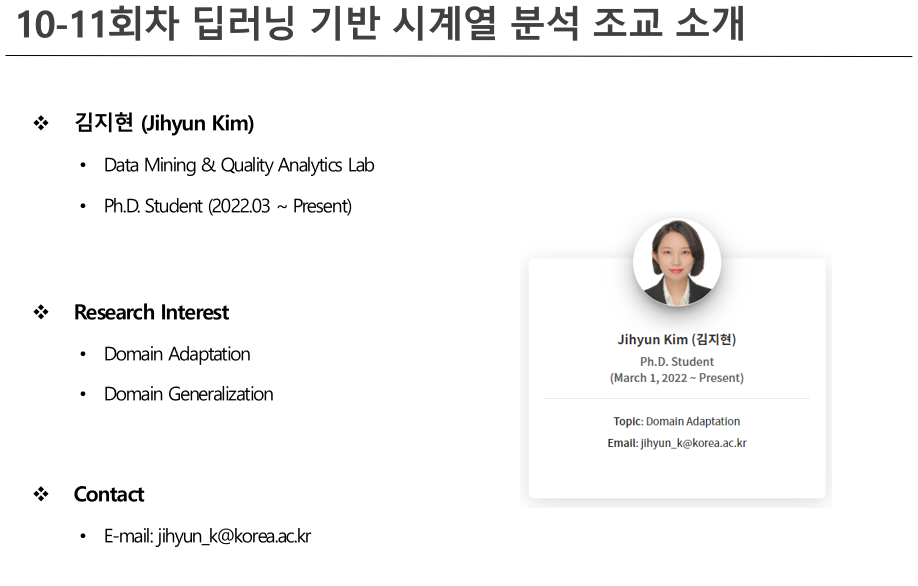

In [3]:
Image('images/img0.PNG')

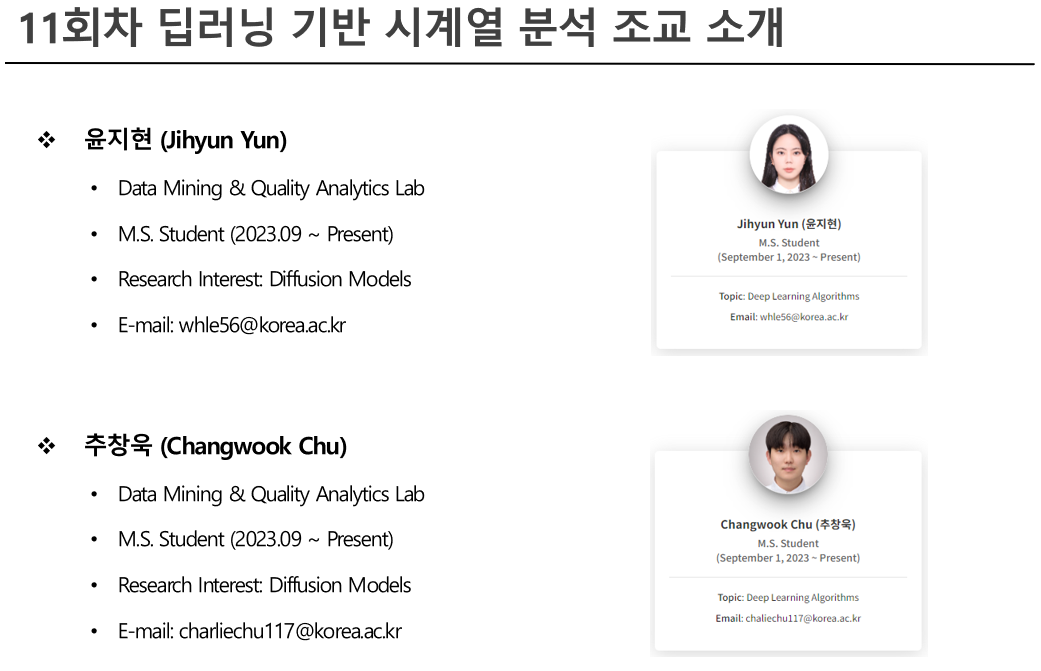

In [4]:
Image('images/img00.PNG')

# TO DO: PyTorch 역전파 알고리즘 함수화 + 전이학습

모델 학습에 필요한 여러가지 모듈을 함수화 하여 편리하게 사용

In [5]:
import os, time
from glob import glob  # glob 모듈에서 glob라는 클래스를 직접적으로 불러오기
import random
import numpy as np
from sklearn.model_selection import train_test_split

import torch

# 데이터 전처리 및 데이터셋 구축을 위함
from PIL import Image as Img
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader

# 모델 구축을 위함
import torch.nn as nn
from torchsummary import summary

# 시각화를 위한 패키지
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## 0. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seedn/Random state 고정
- 실험 결과 재현성을 위함

In [7]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 0
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

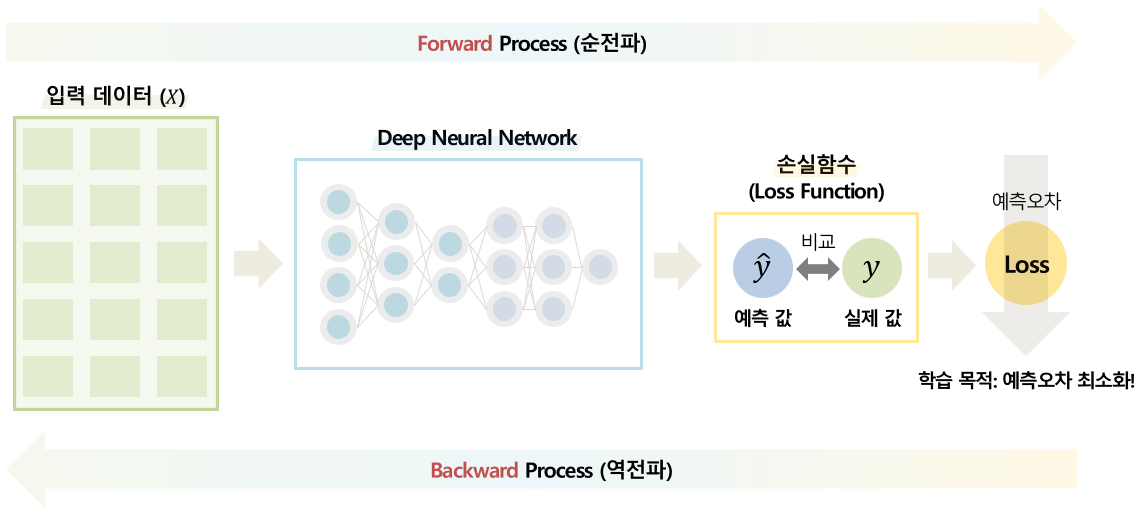

In [8]:
Image('./images/img1.PNG')

## 1. Dataset 및 DataLoader 정의

### 개미와 벌 분류(Classification)하기
- train: class 당 약 120개
- valid: class 당 약 70~80개

### 1-1. 데이터셋 전처리(preprocess) 함수화

In [87]:
def preprocess(data_dir:str='./data/ant_bee'):
    """ 1. Trainset, validset구축 위한 데이터 로드"""
    ant_path = glob(os.path.join(data_dir, 'train/ants/*'))
    ant_labels = [0]*len(ant_path)
    bee_path = glob(os.path.join(data_dir, 'train/bees/*'))
    bee_labels = [1]*len(bee_path)

    """ 2. Train/Valid 분할"""
    ant_train_idx, ant_valid_idx = train_test_split(np.arange(len(ant_path)), train_size=.7, random_state=seed)
    ant_train_path, ant_train_labels = np.asarray(ant_path)[ant_train_idx], np.asarray(ant_labels)[ant_train_idx]
    ant_valid_path, ant_valid_labels = np.asarray(ant_path)[ant_valid_idx], np.asarray(ant_labels)[ant_valid_idx]

    bee_train_idx, bee_valid_idx = train_test_split(np.arange(len(bee_path)), train_size=.7, random_state=seed)
    bee_train_path, bee_train_labels = np.asarray(bee_path)[bee_train_idx], np.asarray(bee_labels)[bee_train_idx]
    bee_valid_path, bee_valid_labels = np.asarray(bee_path)[bee_valid_idx], np.asarray(bee_labels)[bee_valid_idx]

    train_path = list(ant_train_path) + list(bee_train_path)
    train_labels = list(ant_train_labels) + list(bee_train_labels)

    valid_path = list(ant_valid_path) + list(bee_valid_path)
    valid_labels = list(ant_valid_labels) + list(bee_valid_labels)

    """ 3. Testset 구축"""
    ant_test_path = glob(os.path.join(data_dir, 'eval/ants/*'))
    ant_test_labels = [0]*len(ant_path)
    bee_test_path = glob(os.path.join(data_dir, 'eval/bees/*'))
    bee_test_labels = [1]*len(bee_path)

    test_path = list(ant_test_path) + list(bee_test_path)
    test_labels = list(ant_test_labels) + list(bee_test_labels)

    return train_path, train_labels, valid_path, valid_labels, test_path, test_labels

In [59]:
# AntBeeDataset
class AntBeeDataset(Dataset):
    def __init__(self, img_path, labels, mode):
        self.img_path = img_path
        self.labels = labels

        if mode == 'train':
            self.transform = tf.Compose([
                tf.ToPILImage(),
                tf.RandomResizedCrop(224),  # 유의: torchvision에서 사용하는 모델을 활용할 경우 input size는 224 (inception model은 299)
                tf.RandomHorizontalFlip(p=0.5),
                tf.ToTensor(),
                tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else: # valid or test 시에 적용될 데이터 전처리
            self.transform = tf.Compose([
                                    tf.Resize(size=(128,128)),
                                    tf.ToTensor(),
                                    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = Img.open(self.img_path[idx])
        X = self.transform(img)
        y = self.labels[idx]
        return {'X':X, 'y':y}

In [60]:
# 학습/테스트 데이터셋 및 데이터로더 생성

"""1. 사전에 정의된 preprocess 함수를 호출하여 mode 별 img_path, labels 출력"""
train_path, train_labels, valid_path, valid_labels, test_path, test_labels = preprocess(data_dir='./data/ant_bee')

"""2. mode 별 Dataset 생성"""
trainset = AntBeeDataset(img_path=train_path, labels=train_labels,
                         mode='train')

validset = AntBeeDataset(img_path=valid_path, labels=valid_labels,
                         mode='valid')

testset = AntBeeDataset(img_path=test_path, labels=test_labels,
                         mode='test')

"""3. mode 별 DataLoader 생성"""
trainloader = DataLoader(dataset=trainset, 
                         batch_size=32,     # 2의 승수개로 하는 것이 보통
                         shuffle=True,
                         drop_last=False)

validloader = DataLoader(dataset=validset, 
                         batch_size=32,
                         shuffle=False,     # train과 달리 valid, test 시에는 shuffle하지 않음
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

In [61]:
len(trainset)

print(f'trainset 이미지 수 : {len(trainset)}')
print(f'validset 이미지 수 : {len(validset)}')
print(f'testset 이미지 수  : {len(testset)}')

trainset 이미지 수 : 170
validset 이미지 수 : 74
testset 이미지 수  : 153


In [62]:
# AntBeeDataset
class AntBeeDataset2(Dataset):
    def __init__(self, data_dir, mode):
        if mode == 'train':
            self.transform = tf.Compose([
                # tf.ToPILImage(),
                tf.RandomResizedCrop(224), # 유의: torchvision에서 사용하는 모델을 활용할 경우 input size는 224 (inception model은 299)
                tf.RandomHorizontalFlip(p=0.5),
                tf.ToTensor(),
                tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            img_path, labels, _, _, _, _ = self.preprocess(data_dir)
            self.img_path, self.labels = img_path, torch.tensor(labels).long()

        elif mode == 'valid':
            self.transform = tf.Compose([
                                    tf.Resize(size=(224,224)),
                                    tf.ToTensor(),
                                    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
            _, _, img_path, labels, _, _ = self.preprocess(data_dir)
            self.img_path, self.labels = img_path, torch.tensor(labels).long()

        elif mode == 'test':
            self.transform = tf.Compose([
                                    tf.Resize(size=(224,224)),
                                    tf.ToTensor(),
                                    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
            _, _, _, _, img_path, labels = self.preprocess(data_dir)
            self.img_path, self.labels = img_path, torch.tensor(labels).long()
        else: 
            NotImplementedError("'mode' should be one of ['train', 'valid', 'test']")

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = Img.open(self.img_path[idx])
        X = self.transform(img)
        y = self.labels[idx]
        return {'X':X, 'y':y}
    
    def preprocess(self, data_dir):
        """ 1. Trainset, validset구축 위한 데이터 로드"""
        ant_path = glob(os.path.join(data_dir, 'train/ants/*'))
        ant_labels = [0]*len(ant_path)
        bee_path = glob(os.path.join(data_dir, 'train/bees/*'))
        bee_labels = [1]*len(bee_path)

        """ 2. Train/Valid 분할"""
        ant_train_idx, ant_valid_idx = train_test_split(np.arange(len(ant_path)), train_size=.7, random_state=seed)
        ant_train_path, ant_train_labels = np.asarray(ant_path)[ant_train_idx], np.asarray(ant_labels)[ant_train_idx]
        ant_valid_path, ant_valid_labels = np.asarray(ant_path)[ant_valid_idx], np.asarray(ant_labels)[ant_valid_idx]

        bee_train_idx, bee_valid_idx = train_test_split(np.arange(len(bee_path)), train_size=.7, random_state=seed)
        bee_train_path, bee_train_labels = np.asarray(bee_path)[bee_train_idx], np.asarray(bee_labels)[bee_train_idx]
        bee_valid_path, bee_valid_labels = np.asarray(bee_path)[bee_valid_idx], np.asarray(bee_labels)[bee_valid_idx]

        train_path = list(ant_train_path) + list(bee_train_path)
        train_labels = list(ant_train_labels) + list(bee_train_labels)

        valid_path = list(ant_valid_path) + list(bee_valid_path)
        valid_labels = list(ant_valid_labels) + list(bee_valid_labels)

        """ 3. Testset 구축"""
        ant_test_path = glob(os.path.join(data_dir, 'eval/ants/*'))
        ant_test_labels = [0]*len(ant_path)
        bee_test_path = glob(os.path.join(data_dir, 'eval/bees/*'))
        bee_test_labels = [1]*len(bee_path)

        test_path = list(ant_test_path) + list(bee_test_path)
        test_labels = list(ant_test_labels) + list(bee_test_labels)

        return train_path, train_labels, valid_path, valid_labels, test_path, test_labels

In [63]:
data_directory = './data/ant_bee'

trainset = AntBeeDataset2(data_dir=data_directory,
                         mode='train')

validset = AntBeeDataset2(data_dir=data_directory,
                         mode='valid')

testset = AntBeeDataset2(data_dir=data_directory,
                         mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=False)

validloader = DataLoader(dataset=validset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

In [64]:
print(f'trainset 이미지 수 : {len(trainset)}')
print(f'validset 이미지 수 : {len(validset)}')
print(f'testset 이미지 수  : {len(testset)}')

trainset 이미지 수 : 170
validset 이미지 수 : 74
testset 이미지 수  : 153


### Question: 170개의 데이터로 딥러닝 모델을 잘 학습시킬 수 있을까?

In [16]:
# 이미지 시각화를 위한 함수
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Given an interval, values outside the interval are clipped to the interval edges.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [17]:
# 비전 task를 위한 torch
import torchvision

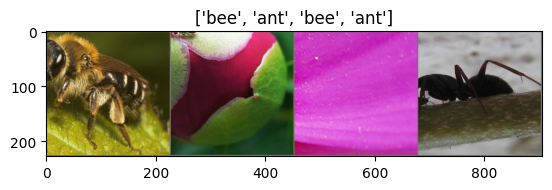

In [72]:
# Get a batch of training data
loader = DataLoader(dataset=trainset, 
                         batch_size=4,
                         shuffle=True,
                         drop_last=False)

batch = next(iter(loader)) # batch, ch, h,w
inputs, labels = batch['X'], batch['y']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # ch,h,width*batch
imshow(out, title=["ant" if label == 0 else "bee" for label in labels])

- 참고: data와 task에 잘 맞는 augmentation 기법을 신중히 선정하는 것 중요

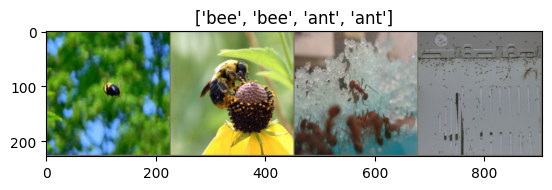

In [74]:
# Get a batch of training data
loader = DataLoader(dataset=validset, 
                         batch_size=4,
                         shuffle=True,
                         drop_last=False)

batch = next(iter(loader)) # batch, ch, h,w
inputs, labels = batch['X'], batch['y']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # ch,h,width*batch
imshow(out, title=["ant" if label == 0 else "bee" for label in labels])

## 2. Deep Neural Network Model 정의

### 2-1. Transfer Learning (전이학습)
- 데이터셋이 딥러닝 모델을 학습시키기에 부족한 상황에서, 사전에 학습된 모델(pretrained model)의 파라미터를 이용하여 나의 task에 맞게 재조정(fine-tuning) 하는 방법을 일컫음
- PyTorch의 `torchvision.models` 에서는 ImageNet 데이터셋을 기반으로 사전학습된 다양한 CNN 모델들이 제공됨
    - AlexNet, VGGNet, GoogLeNet, ResNet, etc.
- 사전학습된 모델의 구조/아키텍처는 저마다 다르기 때문에, 기존의 아키텍처를 잘 살펴보고 각자의 시나리오에 맞게 커스텀 조정하는 것이 필요

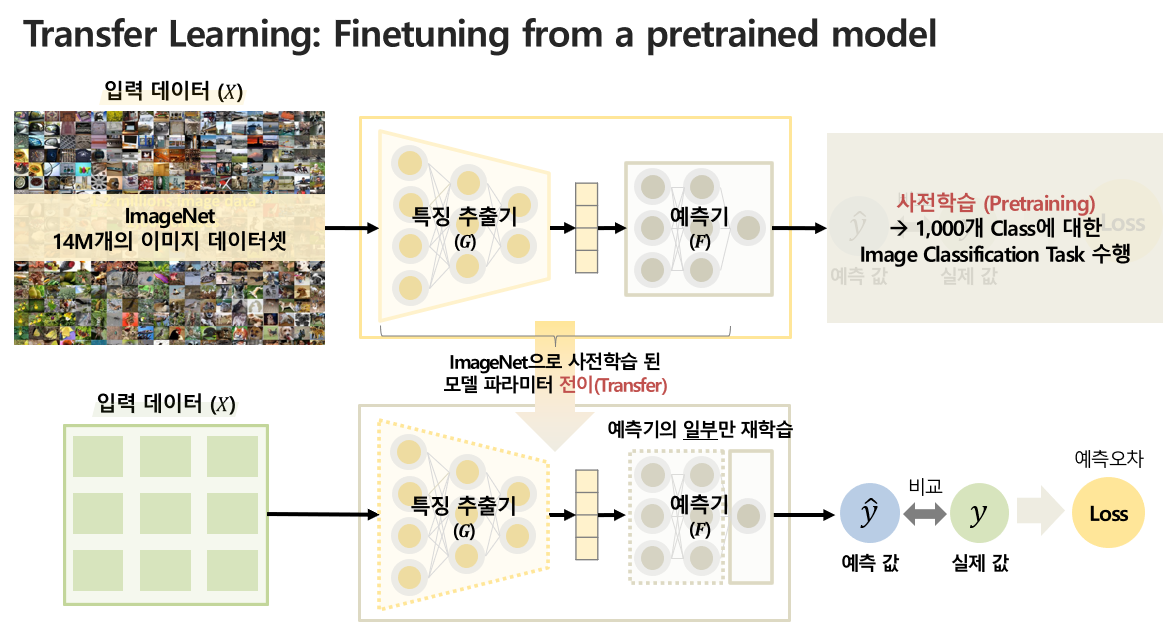

In [ ]:
Image('images/transferlearning.PNG')

#### Question. 왜 사전학습(Pretraining)이 필요할까?
- 특징 추출기가 산출하는 Feature Representation Vector는 우리가 풀고자 하는 task (e.g. 이미지 분류 task)를 잘 수행하기 위해 필요한 입력 데이터의 특성을 잘 반영해야 함
    - 개미와 벌을 구분하기 위해 데이터의 어떤 특성을 잘 파악해야 하는지
- 이때, 우리가 가진 데이터가 아니더라도, 유사한 분포의 다른 이미지로 동일한 task를 사전에 수행했다면 특징 추출기가 이미지를 바라보는 능력이 좋아질 것이라 기대
    - 즉, 사전학습을 수행하면 이미지를 특정 class로 구분하기 위해서 필요한 특성을 잘 추출하는 데 더 유리해지는 것
- 만일 가지고 있는 데이터셋이 딥러닝 모델을 학습시키기에 부족한 경우, 유사한 데이터셋으로 사전학

In [28]:
from torchvision import models  # AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception 등

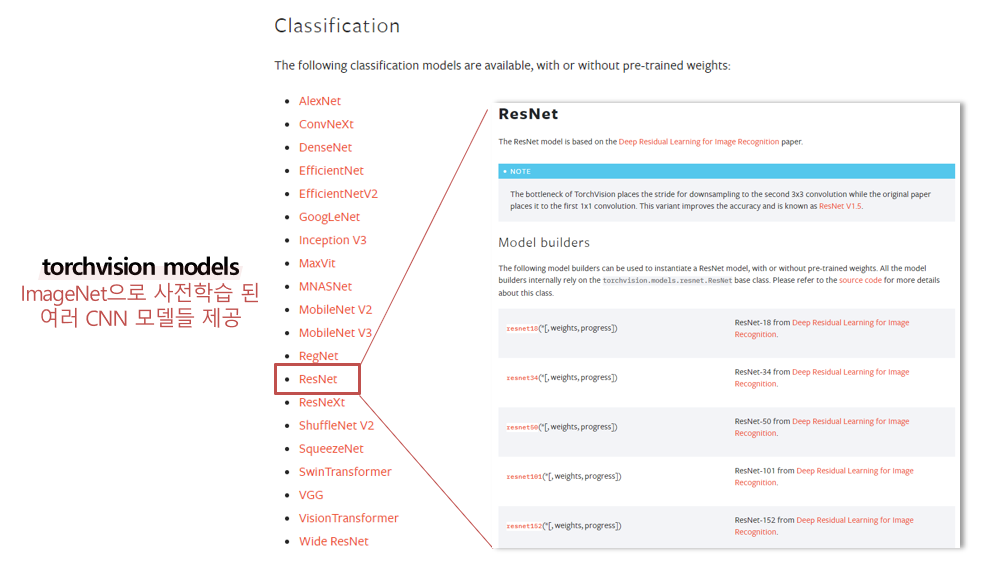

In [29]:
Image('images/torchvision_model.PNG')

### 2-1-1. 네트워크 초기화
- 모델의 어느 레이어만 새롭게 학습(파라미터 업데이트)할 지에 대해 정의 필요
- 새로 정의된 마지막 출력 레이어만을 학습하고 이전 레이어는 학습 불필요
    - 학습, 즉 파라미터(가중치)의 gradient를 계산할 필요가 없음 -> `.requires_grad` 속성을 False로 설정 해야 함
    - 이후 새 layer를 초기화 할 때에는 파라미터(가중치)를 `.requires_grad=True` 로 설정 필요 (fine-tuning의 대상)

In [30]:
alexnet = models.alexnet(pretrained=True)  # pretrained=True 옵션은 사전학습된 모델을 불러오겠다는 의미
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
for param in alexnet.features[0].parameters():  # 기본 설정 값은 'requires_grad=True'
    print(param.requires_grad)

True
True


In [32]:
for param in alexnet.parameters():
    param.requires_grad = False

In [33]:
for param in alexnet.features[0].parameters():  #'requires_grad=False'로 재설정
    print(param.requires_grad)

False
False


### 2-1-2. 네트워크 재구성
- 예측기의 최종 레이어는 데이터셋의 출력 클래스와 동일 수의 노드를 가지고 있음
- `torchvision.models`에서 제공되는 모든 모델은 ImageNet에서 사전학습 되었기 때문에 각 class 당 하나의 노드씩 1000 크기의 출력 레이어를 가지고 있음
- 따라서 **내가 가진 데이터셋의 class 수와 동일한 수의 출력을 갖도록 마지막 레이어를 재구성** 하는 과정이 필요함

In [34]:
alexnet.features  # feature extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [35]:
alexnet.classifier[-1]  # AlexNet classifier (예측기;분류기)의 마지막 레이어

Linear(in_features=4096, out_features=1000, bias=True)

- AlexNet의 마지막 출력 레이어를 살펴보면, out_features=1000인 것을 알 수 있음
- 이는 ImageNet 1000개의 class에 대해서 입력 데이터가 어느 class에 속할 확률이 높은지를 산출하기 위해 설계되었기 때문
- 우리는 개미와 벌을 분류하는 Binary Classification (이진분류) 문제이기 때문에, **out_features 값을 2로 변경**해주어야 함!

In [36]:
in_features = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(in_features, 2)  # 마지막 출력 layer의 구조를 변경하여 재설정!

print(alexnet.classifier[-1])

Linear(in_features=4096, out_features=2, bias=True)


In [37]:
for param in alexnet.classifier[-1].parameters():
    print(param.requires_grad)

True
True


- 마지막 출력 layer는 새롭게 초기화된 것으로 정의하였기 때문에 gradient를 계산하고 파라미터 업데이트 필요!

### 2-1-3. 모델 가중치 초기화 및 재구성 함수화

In [38]:
def initialize_model(model_name:str, num_classes:int, 
                     use_pretrained:bool=True, grad_update:bool=False):
    """
    [함수 실행 시 필요한 인자]
    1. model_name: 어떤 모델을 불러올 것인지 (alexnet, vgg, resnet 중 택 1)
    2. num_classes: 나의 task에서 분류가 필요한 class 개수가 몇 개인지 새롭게 지정
        - 우리의 task는 개미와 벌 2가지 classes를 분류 (num_classes=2)
    3. use_pretrained: 모델을 불러올 때 ImageNet으로 사전학습된 모델을 불러올 것인지를 결정
        - ImageNet으로 사전학습된 모델을 불러올 경우 True
        - 모델의 구조만 이용하고 초기화된 파라미터에서 학습을 시작할 경우 False
    4. grad_update: gradient를 계산하여 업데이트를 할 것인지를 결정
        - torchvision 모델의 파라미터를 이용하고 특정 레이어만 재학습 하고 싶다면 False
        - torchvision 모델의 구조만 이용하고 재학습이 필요하다면 True
    """
    model = None
    if model_name == "alexnet":
        model = models.alexnet(pretrained=use_pretrained)
        if grad_update != True:  # gradient를 통한 update를 하지 않을 것이라면
            for param in model.parameters():
                param.requires_grad = False  # requires_grad=False로 변경
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif model_name == "vgg":  # VGG는 작은 filter (3x3)를 사용해 모델의 깊이를 늘린 CNN.
                               # 작은 필터 여러 개를 사용하면 연산량은 줄이되 비선형성이 증가하여 복잡한 패턴 포착 가능
        model = models.vgg11_bn(pretrained=use_pretrained)  # VGG11에서 Batch Normalization까지 추가
        if grad_update != True:  # gradient를 통한 update를 하지 않을 것이라면
            for param in model.parameters():
                param.requires_grad = False  # requires_grad=False로 변경
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif model_name == "resnet":
        # conv output과 입력 x를 더하여 깊은 층의 CNN에서도 기울기가 잘 전파되도록 모델 구성
        model = models.resnet18(pretrained=use_pretrained)  # ResNet18 모델 이용
        if grad_update != True:  # gradient를 통한 update를 하지 않을 것이라면
            for param in model.parameters():
                param.requires_grad = False  # requires_grad=False로 변경
        in_features = model.fc.in_features   # classifier와 같은 predictor는 fc layer로도 불림
        model.fc = nn.Linear(in_features, num_classes)
    else:
        raise NotImplementedError("Invalid model name. model_name should be one of ['alexnet', 'vgg', 'resnet']")
    
    return model

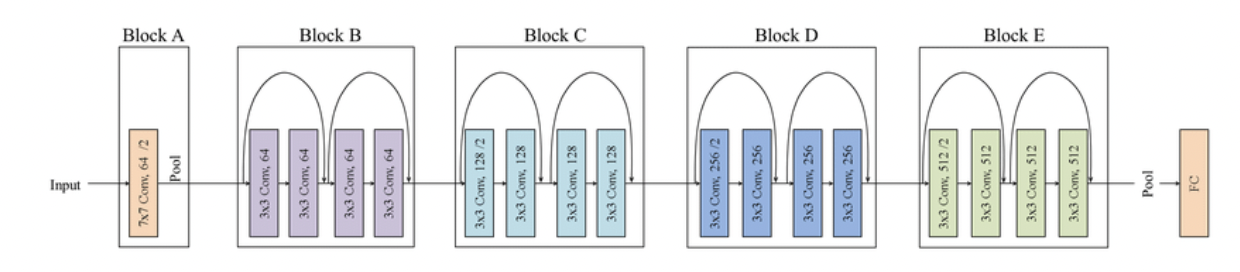

In [39]:
Image('./images/resnet18.PNG')

In [40]:
pretrained_resnet = initialize_model(model_name="resnet", num_classes=2, use_pretrained=True, grad_update=False)
print(pretrained_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2-2. 처음부터 학습시키기
- 전이 학습을 사용하지 않은 경우와 학습 성능을 비교하고 싶을 때
- `initialize_model` 함수에서 `use_pretrained`와 `grad_update` 인자를 각각 `False`, `True`로 바꿔주기

In [41]:
resnet = initialize_model(model_name="resnet", num_classes=2, use_pretrained=False, grad_update=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Loss Function & Optimizer 정의

### 3-1. Loss Function 정의
- Cross Entropy Loss!

In [42]:
criterion = nn.CrossEntropyLoss()

### 3-2. Optimizer 정의

- 전이학습을 위해서 원하는 파라미터만 업데이트하는 옵티마이저를 생성
    - 사전 학습된 모델을 읽어 들인 후 구조를 재조정하기 전에 `feature_extract=True`인 경우 파라미터의 모든 `.requires_grad` 속성을 일일이 False로 설정한 것 유의
    - 재초기화된 레이어 (우리의 경우 마지막 출력 레이어)의 파라미터는 기본적으로 `.requires_grad=True`를 가짐에 유의
- 이제 *`.requires_grad=True`인 모든 파라미터를 최적화* 하기 위해 업데이트 대상이 되는 파라미터 목록을 만들고 이 목록을 SGD 알고리즘 생성자(constructor)에 입력

In [43]:
print("Case 1. Using Pretrained ResNet, Params to learn:")
for name,param in pretrained_resnet.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

print("Case 2. Using ResNet, Params to learn:")
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

Case 1. Using Pretrained ResNet, Params to learn:
	 fc.weight
	 fc.bias
Case 2. Using ResNet, Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3

In [44]:
pretrained_optimizer = torch.optim.SGD([param for param in pretrained_resnet.parameters() if param.requires_grad == True], 
                                       lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [75]:
def get_optimizer(configs, model):

    """Step 1. 업데이트 할 모델 파라미터 정의 -> params_to_update라는 변수로"""
    if configs['use_pretrained']:
        # 리스트 컴프리헨션 문법!! 공부해두면 좋아요
        params_to_update = [param for param in model.parameters() if param.requires_grad == True]
    else:
        params_to_update = model.parameters()

    """Step 2. 파라미터를 업데이트 할 optimizer 정의 -> optimizer라는 변수로"""
    if configs['optimizer'] == "SGD":
        optimizer = torch.optim.SGD(params=params_to_update, lr=configs['learning_rate'], 
                                    momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(params=params_to_update, lr=configs['learning_rate'], 
                                    bestas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['SGD', 'Adam']. Exiting...")
        exit()

    return optimizer

#### 학습 준비 완료!

---------------------

## 4. Forward & Backward 함수화
- 모델을 학습시키는 모든 과정을 함수화 해보자!
    1. 데이터 로드
    2. 모델 정의
    3. Optimizer, Loss function 정의
    4. Train, Valid, Test 등 역전파 알고리즘 정의
    5. 모델 학습 및 평가 알고리즘 실행

### 4-1. 학습에 필요한 하이퍼파라미터 정의
- 모델을 학습시키는 데 사용자가 직접 정의 해주어야 하는 모든 값들을 사전에 지정
- 학습을 위해 필요한 값들을 설정 (configuration)

In [45]:
configs = { # 모델 관련 하이퍼파라미터들
            'model_name': 'resnet',  # resnet18
            'num_classes':2,
            'use_pretrained': True,

            # Optimizer 관련 하이퍼파라미터들
            'optimizer': 'SGD',
            'learning_rate':1e-3,
            'momentum': 0.9,
            'weight_decay':.0,

            # 학습 관련 하이퍼파라미터들
            'seed':0,
            'num_epochs':15,
            'batch_size':32,
            
            # directory 관련 하이퍼파라미터들
            'data_dir': './data/ant_bee/',
            'save_dir': './results/'}

### 4-2. Train 과정 함수화

In [46]:
def train(device, model, trainloader, criterion, optimizer):
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                    'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수
    
    for i, batch in enumerate(trainloader):
        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

        # forward
        logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

        # Loss 계산!
        loss = criterion(logits, labels)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산!
        max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                        # logit의 max 값은 모델이 해당 class로 예측했다는 의미
        accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
        train_history['accuracy'][i] = accuracy

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기 

    return train_result

### 4-3. Valid (Evaluate) 과정 함수화

In [47]:
def evaluate(device, model, validloader, criterion):
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실(loss)을 기록하기 위함
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위함

    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            input_imgs, labels = batch['X'].to(device), batch['y'].to(device)
            logits = model(input_imgs)

            loss = criterion(logits, labels)

            """loss를 backward 하지 않는 것에 주의"""

            # 모델 손실 및 성능 기록
            max_pred = torch.max(logits.detach(), dim=-1)[1]
            accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장
            valid_history['accuracy'][i] = accuracy  # 모델 성능 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()}

    return valid_result

### 4-4. 모델 학습 추세 시각화 함수화

In [48]:
def visualize_model_training(configs, epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['train_loss'], label="Train Loss")
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['valid_loss'], label="Valid Loss")
    plt.title("Train vs Valid Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

    # 성능(Accuracy) 추세 시각화
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['train_acc'], label="Train Accuracy")
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['valid_acc'], label="Valid Accuracy")
    plt.title("Train vs Valid Accuracy Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show();

### 4-5. 모델 파라미터 저장 함수화
- Save parameters of the trained model

In [49]:
def save_checkpoint(save_dir, model):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    save_model_dir = os.path.join(save_dir, 'antbee_model_checkpoint.pt')

    save_dict = {'model': model.state_dict()}
    torch.save(save_dict, save_model_dir)

### 4-6. Test 과정 함수화

In [50]:
def test(device, configs, model, testloader):
    saved_model = torch.load(os.path.join(configs['save_dir'], 'antbee_model_checkpoint.pt')) # 모델 불러오기
    parameters = saved_model['model']  # 'model'의 파라미터 불러오기
    model.load_state_dict(parameters, strict=False)

    num_iterations = len(testloader)
    test_history = {'accuracy': torch.zeros(num_iterations)}

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            input_imgs, labels = batch['X'].to(device), batch['y'].to(device)
            
            logits = model(input_imgs) # B,2
            
            # max함수를 통한 예측값 생성
            max_pred = torch.max(logits, dim=1)[1] # B
            test_accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)
            test_history['accuracy'][i] = test_accuracy

    test_result = {k: v.mean().item() for k, v in test_history.items()} 

    return test_result

### 4-7. 모든 학습 프레임워크 함수화

In [76]:
def main(configs, trainloader, validloader, testloader):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # seed 정의
    torch.manual_seed(configs['seed']) # torch cpu seed 고정
    torch.cuda.manual_seed(configs['seed']) # torch gpu seed 고정
    torch.cuda.manual_seed_all(configs['seed']) # torch multi-gpu seed 고정
    np.random.seed(configs['seed']) # numpy seed 고정
    random.seed(configs['seed']) # python seed 고정

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")
    
    # 모델 정의하기
    model = initialize_model(model_name=configs['model_name'], num_classes=configs['num_classes'],
                            use_pretrained=configs['use_pretrained'], 
                            grad_update=False if configs['use_pretrained'] else True)  # configs['use_pretrained']가 True라면 False, 아니라면 True
                                                                                       # 사전학습된 모델을 사용하면 grad update 필요 X이기 때문
     
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.CrossEntropyLoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)

    # training
    best_acc = 0.0              # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'train_acc': [],
                     'valid_loss': [], 'valid_acc': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, trainloader, criterion, optimizer)     # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)  # 앞서 정의해두었던 함수 호출

        print(f"Train Loss: {train_result['loss']:.2f} | Train Accuracy: {train_result['accuracy']:.2f}")
        print(f"Valid Loss: {valid_result['loss']:.2f} | Valid Accuracy: {valid_result['accuracy']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['train_acc'].append(train_result['accuracy'])
        epoch_history['valid_loss'].append(valid_result['loss'])
        epoch_history['valid_acc'].append(valid_result['accuracy'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        if valid_result['accuracy'] > best_acc:
            best_acc = valid_result['accuracy']  # best acc 값 업데이트
            best_epoch = epoch                   # best epoch 값 업데이트
            save_checkpoint(configs['save_dir'], model)  # 앞서 정의해두었던 함수 호출

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Accuracy:{best_acc:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(configs, epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, configs, model, testloader)
    print(f"Test Accuracy  : {test_result['accuracy']:.2f} \n")

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

In [77]:
### Remind: Hyperparameter ###
configs = { # 모델 관련 하이퍼파라미터들
            'model_name': 'resnet',  # resnet18
            'num_classes':2,
            'use_pretrained': True,

            # Optimizer 관련 하이퍼파라미터들
            'optimizer': 'SGD',
            'learning_rate':1e-3,
            'momentum': 0.9,
            'weight_decay':.0,

            # 학습 관련 하이퍼파라미터들
            'seed':0,
            'num_epochs':15,
            'batch_size':32,
            'visualize': True,  # 모델 학습 추세 시각화 여부
            
            # directory 관련 하이퍼파라미터들
            'data_dir': './data/ant_bee/',
            'save_dir': './results/'}

### 4-8. `main()` 함수 실행을 통해 학습 및 평가 과정 일괄 수행

Configurations: 
 {'model_name': 'resnet', 'num_classes': 2, 'use_pretrained': True, 'optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.9, 'weight_decay': 0.0, 'seed': 0, 'num_epochs': 15, 'batch_size': 32, 'visualize': True, 'data_dir': './data/ant_bee/', 'save_dir': './results/'}
--------------- Epoch: 1 ---------------
Train Loss: 0.75 | Train Accuracy: 0.45
Valid Loss: 0.75 | Valid Accuracy: 0.44
--------------- Epoch: 2 ---------------
Train Loss: 0.72 | Train Accuracy: 0.55
Valid Loss: 0.62 | Valid Accuracy: 0.76
--------------- Epoch: 3 ---------------
Train Loss: 0.60 | Train Accuracy: 0.70
Valid Loss: 0.54 | Valid Accuracy: 0.79
--------------- Epoch: 4 ---------------
Train Loss: 0.52 | Train Accuracy: 0.78
Valid Loss: 0.43 | Valid Accuracy: 0.91
--------------- Epoch: 5 ---------------
Train Loss: 0.41 | Train Accuracy: 0.88
Valid Loss: 0.30 | Valid Accuracy: 0.94
--------------- Epoch: 6 ---------------
Train Loss: 0.34 | Train Accuracy: 0.90
Valid Loss: 0.24 | Valid

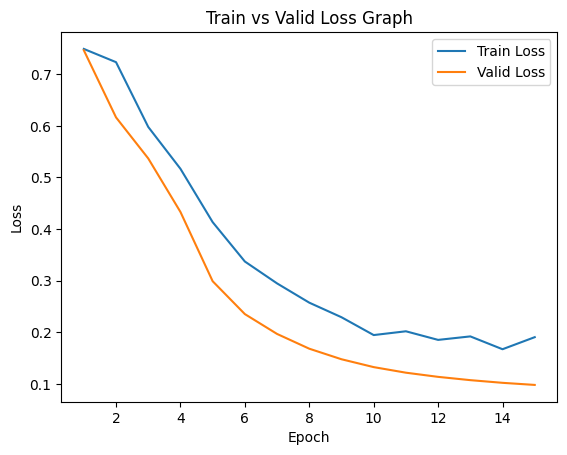

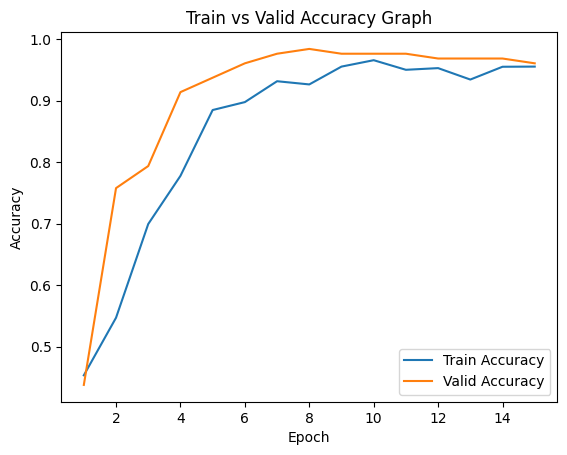

Test Accuracy  : 0.66 

Total Training Time: 0.40 minutes


In [78]:
# 최종 main 함수 실행!!
test_result = main(configs, trainloader, validloader, testloader)

### 4-8. 비교: 사전학습을 하지 않았을 때

In [84]:
### Remind: Hyperparameter ###
configs2 = { # 모델 관련 하이퍼파라미터들
            'model_name': 'resnet',  # resnet18
            'num_classes':2,
            'use_pretrained': False,  ### 사전학습 X ###

            # Optimizer 관련 하이퍼파라미터들
            'optimizer': 'SGD',
            'learning_rate':1e-3,
            'momentum': 0.9,
            'weight_decay':.0,

            # 학습 관련 하이퍼파라미터들
            'seed':0,
            'num_epochs':15,
            'batch_size':32,
            'visualize': True,  # 모델 학습 추세 시각화 여부
            
            # directory 관련 하이퍼파라미터들
            'data_dir': './data/ant_bee/',
            'save_dir': './results/not_pretrained'}

Configurations: 
 {'model_name': 'resnet', 'num_classes': 2, 'use_pretrained': False, 'optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.9, 'weight_decay': 0.0, 'seed': 0, 'num_epochs': 15, 'batch_size': 32, 'visualize': True, 'data_dir': './data/ant_bee/', 'save_dir': './results/not_pretrained'}
--------------- Epoch: 1 ---------------
Train Loss: 0.71 | Train Accuracy: 0.46
Valid Loss: 0.69 | Valid Accuracy: 0.44
--------------- Epoch: 2 ---------------
Train Loss: 0.71 | Train Accuracy: 0.47
Valid Loss: 0.66 | Valid Accuracy: 0.73
--------------- Epoch: 3 ---------------
Train Loss: 0.69 | Train Accuracy: 0.52
Valid Loss: 0.67 | Valid Accuracy: 0.72
--------------- Epoch: 4 ---------------
Train Loss: 0.68 | Train Accuracy: 0.58
Valid Loss: 0.68 | Valid Accuracy: 0.58
--------------- Epoch: 5 ---------------
Train Loss: 0.67 | Train Accuracy: 0.63
Valid Loss: 0.68 | Valid Accuracy: 0.58
--------------- Epoch: 6 ---------------
Train Loss: 0.65 | Train Accuracy: 0.66
Valid Los

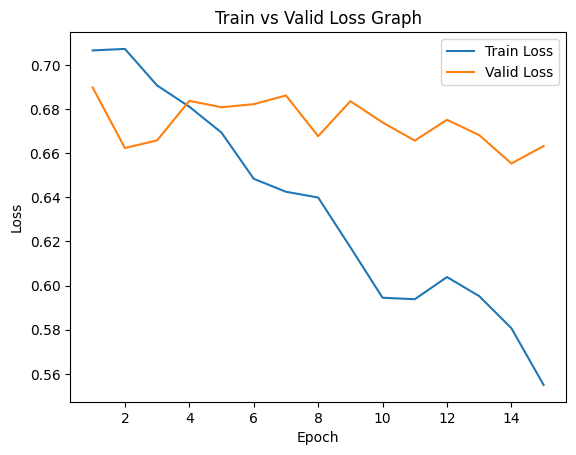

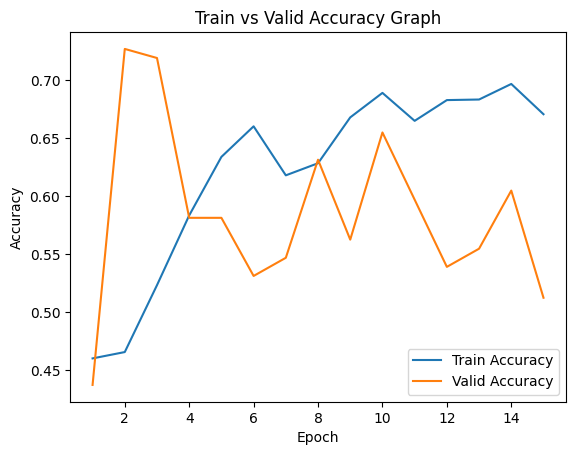

Test Accuracy  : 0.43 

Total Training Time: 0.38 minutes


In [85]:
# 최종 main 함수 실행!!
test_result = main(configs2, trainloader, validloader, testloader)